In [149]:
import pandas as pd
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import netwulf as nw
from scipy.optimize import minimize
import scipy as scp
from scipy.spatial import distance_matrix
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set_theme()

**Functions used to simulate relations between labels**

In [150]:
#given "points" with labels a and b we can assign probability of an edge between them
def basic_func(a,b):
    if a == b:
        return .8
    else:
        return .2

def basic_func2(a,b):
    if a == 1 and b == 1:
        return .8
    if a == 0 and b == 0:
        return .6
    else:
        return .2
def basic_func3(a,b):
    if a == b:
        return .01
    return np.abs(a-b)
def basic_func4(a,b):
    if a == b:
        return .01
    return (a-b)**2

**Creation of an CSBM**

In [151]:
def create_graph(num_nodes, labels, func):
    G = nx.Graph()
    for i in range(num_nodes):
        G.add_node(i, group=labels[i])
        for j in range(i):
            if func(labels[i], labels[j]) != func(labels[j],labels[i]):
                print("WARNING, asymetric function")
            if np.random.rand() < func(labels[i], labels[j]):
                G.add_edge(i, j)
    return G
def create_transition_matrix(labels, func):
    matrix = []
    for i in range(len(labels)):
        arr = []
        for j in range(len(labels)):
            if func(labels[i], labels[j]) != func(labels[j],labels[i]):
                print("WARNING, asymetric function")
            arr.append(func(labels[i], labels[j]))
        matrix.append(arr)
    return np.array(matrix)

**Useful functions**

In [171]:
#input is a numpy array of labels
def sigmoid(x):
     return 1 / (1 + np.exp(-x))
def inv_sigmoid(x):
    return np.log(x/(1-x))
def sigmoid_prime(x):
     return np.exp(x) / np.square(1 + np.exp(x))
def fit_matrix(labels):
    array = labels.T @ labels
    return sigmoid(array)
def matrix_log_likelihood(sample,X):
    sample_complement= 1-sample - np.identity(sample.shape[0])
    return np.sum(np.multiply(sample, np.log(X)) + np.multiply(sample_complement, np.log(1-X)))/sample.shape[0]**2
def log_likelihood(sample,labels, use_sigmoid=True):
    sample_complement= 1-sample - np.identity(sample.shape[0])
    #print("sample",sample)
    #print("compliment",sample_complement)
    if use_sigmoid:
        X = fit_matrix(labels)
    else:
        X = labels
    #print(X)
    log_errs = np.multiply(sample, np.log(X)) + np.multiply(sample_complement, np.log(1-X))
    #print(log_errs)
    return np.sum(log_errs)/sample.shape[0]**2

In [153]:
def projection_derivative(A, X):
    A_complement= 1-A - np.identity(A.shape[0])
    derivs = np.multiply(A, sigmoid(-X)) + np.multiply(A_complement, -sigmoid(X))
    return derivs

In [164]:
def projection_descent(A, step_size=.01, steps =100, params = 2):
    n = len(A)
    cur_matrix = np.zeros(shape=A.shape)
    likelihoods = []
    #print(cur_matrix.shape)
    for i in range(steps):
        for j in range(100):
            #print(projection_derivative(A, cur_matrix).shape)
            derivs = projection_derivative(A, cur_matrix)
            cur_matrix += derivs*step_size
        vals, vecs = scp.linalg.eig(cur_matrix)

        D = np.zeros(shape=(A.shape), dtype=float)
        D[:params, :params] = np.diag(vals.real)[:params,:params]
        cur_matrix = vecs@ D @vecs.T
        #print(cur_matrix.shape)
        likelihoods.append(np.abs(matrix_log_likelihood(A, sigmoid(cur_matrix))))
        print(i, np.abs(matrix_log_likelihood(A, sigmoid(cur_matrix))))
    return cur_matrix, likelihoods

In [160]:
def rank_d_approx(M, d):
    vals, vecs = scp.linalg.eig(M)

    D = np.zeros(shape=(M.shape), dtype=float)
    D[:d, :d] = np.diag(vals.real)[:d,:d]
    cur_matrix = vecs@ D @vecs.T
    return np.abs(cur_matrix)
def frob_dist(X,Y):
    return np.sum((X-Y)**2)/(len(X)*len(X[0]))

In [155]:
def get_labels(A, num_labels=2):
    vals, vecs = scp.linalg.eig(A)
        
    D = np.zeros(shape=(A.shape), dtype=float)
    D[:num_labels, :num_labels] = np.diag(vals.real)[:num_labels,:num_labels]
    
    labels = []
    #print(vecs.T[1]*(D[1][1]))
    for i in range(num_labels):
        #print(D[i][i])
        labels.append(vecs.T[i]*np.sqrt(D.astype('complex128')[i][i]))
        #print(i)
    return np.array(labels)
    
    #matrix_log_likelihood(A, sigmoid(vecs@ D @ vecs.T))

# Inputing the blog posts graph

In [256]:
G = nx.read_gml("polblogs.gml")
G = nx.Graph(G)
G = nx.to_undirected(G)

In [257]:
G.nodes(data=True)

NodeDataView({'100monkeystyping.com': {'value': 0, 'source': 'Blogarama'}, '12thharmonic.com/wordpress': {'value': 0, 'source': 'BlogCatalog'}, '40ozblog.blogspot.com': {'value': 0, 'source': 'Blogarama,BlogCatalog'}, '4lina.tblog.com': {'value': 0, 'source': 'Blogarama'}, '750volts.blogspot.com': {'value': 0, 'source': 'Blogarama'}, '95theses.blogspot.com': {'value': 0, 'source': 'Blogarama'}, 'abbadabbaduo.blogspot.com': {'value': 0, 'source': 'Blogarama,LeftyDirectory'}, 'aboutpolitics.blogspot.com': {'value': 0, 'source': 'Blogarama,eTalkingHead'}, 'achingandspinning.blogspot.com': {'value': 0, 'source': 'Blogarama'}, 'ackackack.com': {'value': 0, 'source': 'BlogCatalog'}, 'adamtalib.blogspot.com': {'value': 0, 'source': 'Blogarama'}, 'adviceforlefty.blogspot.com': {'value': 0, 'source': 'Blogarama,BlogCatalog,CampaignLine'}, 'agonist.org': {'value': 0, 'source': 'LeftyDirectory'}, 'aintnobaddude.com': {'value': 0, 'source': 'LeftyDirectory,CampaignLine'}, 'ajbenjaminjr.blogspot.co

In [258]:
L = np.array([list(G.nodes(data=True))[i][1]['value'] for i in range(len(G.nodes))])

In [259]:
M = nx.to_numpy_array(G)

In [260]:
output, losses = projection_descent(M, step_size=.2, steps=80, params=2)

0 0.08812385740831853
1 0.06531554125159379
2 0.057985824457758336
3 0.054332739825480536
4 0.052157137530899615
5 0.05072674515060038
6 0.04971996826482628
7 0.048973981058482365
8 0.04839862624784135
9 0.04794053553695413
10 0.04756636137805017
11 0.047254298695128885
12 0.046989527196708444
13 0.04676163325630602
14 0.04656308630450719
15 0.04638830321555465
16 0.046233053911425036
17 0.046094072117137196
18 0.045968793440624385
19 0.045855174773845535
20 0.0457515670011123
21 0.045656623486534716
22 0.04556923309807415
23 0.04548847039138747
24 0.04541355801094699
25 0.04534383793268669
26 0.045278749201397614
27 0.0452178105046488
28 0.04516060639381981
29 0.04510677628721019
30 0.0450560056180062
31 0.045008018652120195
32 0.04496257261795223
33 0.04491945287555806
34 0.04487846891579243
35 0.04483945102704242
36 0.04480224750262149
37 0.04476672228882661
38 0.04473275299432564
39 0.044700229197500205
40 0.04466905100079623
41 0.044639127790882784
42 0.04461037717110755
43 0.0445

Text(0.5, 1.0, 'Blog Post Dataset Log Loss over Time')

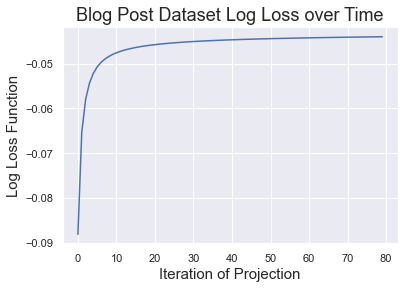

In [261]:
plt.plot(-np.array(losses))
plt.xlabel('Iteration of Projection', fontsize=15)
plt.ylabel('Log Loss Function', fontsize=15)
plt.title('Blog Post Dataset Log Loss over Time', fontsize=18)

In [262]:
log_likelihood(M, np.clip(rank_d_approx(M,2),.0001,.9999), use_sigmoid=False)

-0.0427427238127798

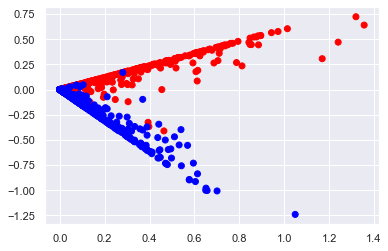

In [263]:
eigen_labels = np.real(get_labels(rank_d_approx(M,2))) + np.imag(get_labels(rank_d_approx(M,2)))
plt.scatter(eigen_labels[0],eigen_labels[1], color = ["red" if elt == 0 else "blue" for elt in L])

In [182]:
labels = np.real(get_labels(sigmoid(output))) + np.imag(get_labels(sigmoid(output)))

In [187]:
get_labels(sigmoid(output))

array([[ 0.11432509+1.19309351e-33j,  0.33863971-6.01348064e-34j,
         0.00746645-1.78675608e-37j, ...,  0.00729439-8.46432806e-36j,
         0.00653636-1.42652618e-36j,  0.00701325-3.21416284e-37j],
       [ 0.00293064-1.26595528e-34j, -0.00934104+2.23329305e-35j,
         0.00947617-9.60223896e-36j, ...,  0.01223889-1.71657722e-35j,
         0.08450195+9.61138520e-37j,  0.01212064-8.93479155e-36j]])

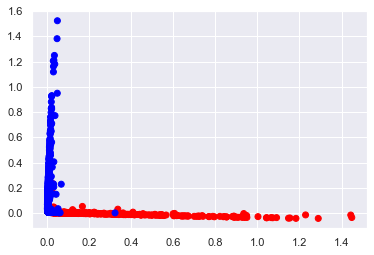

In [184]:
plt.scatter(labels[0],labels[1], color = ["red" if elt == 0 else "blue" for elt in L])

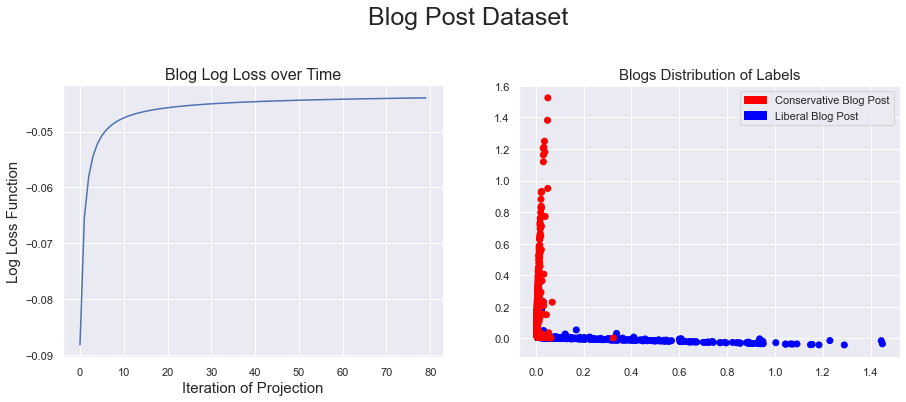

In [195]:
fig=plt.figure(figsize=(15,10))
fig.set_figheight(11)
fig.set_figwidth(15)
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
fig.suptitle('Blog Post Dataset', fontsize=25)
ax1.plot(-np.array(losses))
ax1.set_xlabel('Iteration of Projection', fontsize=15)
ax1.set_ylabel('Log Loss Function', fontsize=15)
ax1.set_title('Blog Log Loss over Time', fontsize=16)
#ax2 = Axes3D(fig)
ax2.scatter(labels[0], labels[1], color = ["blue" if elt == 0 else "red" for elt in L])
ax2.set_title("Blogs Distribution of Labels", fontsize=15)

red_patch = mpatches.Patch(color='red', label='Conservative Blog Post')
blue_patch = mpatches.Patch(color='blue', label='Liberal Blog Post')
ax2.legend(handles=[red_patch, blue_patch])

In [90]:
Labels = get_labels(output, num_labels=4)
labels = np.absolute(Labels)

[-38.52082251-4.87074966e-31j -63.88950739+4.08514488e-31j
  -0.08354589+4.19193803e-32j ...   5.24243904+6.48123947e-32j
  51.78598277+9.42725740e-32j   3.93747093+3.33882033e-32j]
-8893.343522760762
0
1305.3098401004934
1
850.6434876246975
2
-587.7023969893166
3


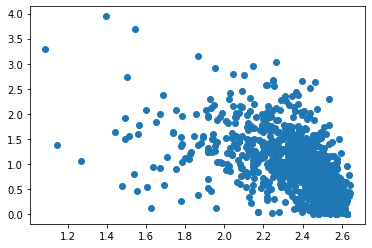

In [92]:
plt.scatter(np.absolute(labels)[0], np.absolute(labels)[1])

In [93]:
list(G.nodes)

['100monkeystyping.com',
 '12thharmonic.com/wordpress',
 '40ozblog.blogspot.com',
 '4lina.tblog.com',
 '750volts.blogspot.com',
 '95theses.blogspot.com',
 'abbadabbaduo.blogspot.com',
 'aboutpolitics.blogspot.com',
 'achingandspinning.blogspot.com',
 'ackackack.com',
 'adamtalib.blogspot.com',
 'adviceforlefty.blogspot.com',
 'agonist.org',
 'aintnobaddude.com',
 'ajbenjaminjr.blogspot.com',
 'alicublog.blogspot.com',
 'allanjenkins.typepad.com',
 'allspinzone.blogspot.com',
 'alphapredator.com/wdtgw.htm',
 'alternateworlds.blogspot.com',
 'althippo.blogspot.com',
 'alvintostig.typepad.com',
 'americablog.blogspot.com',
 'americablog.org',
 'americandreamslost.blogspot.com',
 'americanmuslim.blogs.com',
 'americanpolitics.com',
 'americansforbayh.blogspot.com',
 'amleft.blogspot.com',
 'amliberal.com/blog',
 'amptoons.com/blog',
 'anarchyxero.robfindlay.org',
 'andifeelfine.blogspot.com',
 'andymatic.com',
 'angrybear.blogspot.com',
 'angrydesi.typepad.com',
 'angryfinger.org',
 'angry

In [94]:
l = list(G.nodes)

In [95]:
l.index('liberaloasis.com')

362

In [96]:
l.index('liberalangst.org')

359

In [97]:
l.index('conservativessuck.blogspot.com')

141

In [98]:
l.index('conservativeblogger.com')

902

In [99]:
l.index('conservativenation.us')

909

In [100]:
l.index('conservativeresponse.com')

914

In [101]:
labels[:,362]

array([1.86455775, 3.14392692, 0.76561637, 0.66916516])

In [102]:
labels[:,359]

array([2.55295942, 0.34733931, 0.60516705, 0.44678158])

In [103]:
labels[:,141]

array([2.46565137, 0.3218959 , 0.23703704, 0.49523829])

In [104]:
labels[:,902]

array([2.56025119, 0.69966205, 0.65732146, 0.11761084])

In [105]:
labels[:,909]

array([2.58273958, 0.16058757, 0.3365258 , 0.51280878])

In [81]:
labels[:,914]

array([2.32565803, 0.40120961, 0.2636389 ])

In [88]:
sigmoid(np.real(output))

array([[0.02096127, 0.036792  , 0.00543431, ..., 0.00537405, 0.00360682,
        0.00538997],
       [0.036792  , 0.0878658 , 0.00590288, ..., 0.00568171, 0.00224845,
        0.0056784 ],
       [0.00543431, 0.00590288, 0.00477711, ..., 0.00510312, 0.00831587,
        0.00496538],
       ...,
       [0.00537405, 0.00568171, 0.00510312, ..., 0.00547275, 0.00930302,
        0.00531475],
       [0.00360682, 0.00224845, 0.00831587, ..., 0.00930302, 0.03354652,
        0.00903208],
       [0.00538997, 0.0056784 , 0.00496538, ..., 0.00531475, 0.00903208,
        0.00517313]])

In [85]:
M

array([[0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [86]:
output

array([[-3.84389463-2.55951006e-32j, -3.26498891-7.68438569e-33j,
        -5.20957431-5.89145291e-33j, ..., -5.22078558-5.57677169e-33j,
        -5.62131623-9.79300545e-33j, -5.21781149-7.78676149e-33j],
       [-3.26498891-7.68438569e-33j, -2.33997653-1.66383810e-32j,
        -5.126395  +3.38619270e-33j, ..., -5.16480583+3.17725018e-33j,
        -6.09526474+1.37596357e-32j, -5.16539127+2.50684303e-33j],
       [-5.20957431-5.89145291e-33j, -5.126395  +3.38619270e-33j,
        -5.33913158+2.35920226e-33j, ..., -5.27278754+3.50072422e-33j,
        -4.78123866+1.97719833e-33j, -5.30028678+1.82807871e-33j],
       ...,
       [-5.22078558-5.57677169e-33j, -5.16480583+3.17725018e-33j,
        -5.27278754+3.50072422e-33j, ..., -5.20248621+4.84611257e-33j,
        -4.66807012+3.27730898e-33j, -5.23193965+3.03448495e-33j],
       [-5.62131623-9.79300545e-33j, -6.09526474+1.37596357e-32j,
        -4.78123866+1.97719833e-33j, ..., -4.66807012+3.27730898e-33j,
        -3.3606999 -1.52731064e-33j

In [112]:
np.real(sigmoid(output))[909][904]

0.001149740424544718

In [113]:
np.real(sigmoid(output))[909][141]

0.0011653596603920426

In [114]:
np.real(sigmoid(output))

array([[0.01983964, 0.03001107, 0.0027673 , ..., 0.00260633, 0.00072801,
        0.00242025],
       [0.03001107, 0.05057741, 0.00309157, ..., 0.00306354, 0.00021533,
        0.00193788],
       [0.0027673 , 0.00309157, 0.00118356, ..., 0.00143396, 0.0041339 ,
        0.00153848],
       ...,
       [0.00260633, 0.00306354, 0.00143396, ..., 0.00183618, 0.00859157,
        0.00205751],
       [0.00072801, 0.00021533, 0.0041339 , ..., 0.00859157, 0.10892474,
        0.00471816],
       [0.00242025, 0.00193788, 0.00153848, ..., 0.00205751, 0.00471816,
        0.00169554]])

# Word Adjacencies Graph

In [264]:
G = nx.read_gml("adjnoun.gml")
G = nx.Graph(G)
G = nx.to_undirected(G)

In [265]:
G.nodes

NodeView(('agreeable', 'man', 'old', 'person', 'anything', 'short', 'arm', 'round', 'aunt', 'first', 'bad', 'air', 'boy', 'beautiful', 'black', 'face', 'letter', 'little', 'young', 'best', 'course', 'friend', 'love', 'part', 'room', 'thing', 'time', 'way', 'better', 'heart', 'mind', 'place', 'right', 'state', 'woman', 'word', 'door', 'eye', 'bright', 'evening', 'morning', 'certain', 'day', 'other', 'child', 'happy', 'common', 'dark', 'kind', 'night', 'dear', 'good', 'home', 'mother', 'pretty', 'open', 'early', 'fire', 'full', 'great', 'master', 'moment', 'work', 'general', 'fancy', 'voice', 'head', 'hope', 'long', 'greater', 'hand', 'hard', 'red', 'life', 'glad', 'large', 'new', 'white', 'late', 'whole', 'light', 'manner', 'bed', 'house', 'low', 'money', 'ready', 'small', 'strange', 'thought', 'lost', 'alone', 'nothing', 'miserable', 'natural', 'half', 'wrong', 'name', 'pleasant', 'possible', 'side', 'perfect', 'poor', 'quiet', 'same', 'strong', 'something', 'true', 'usual', 'family', 

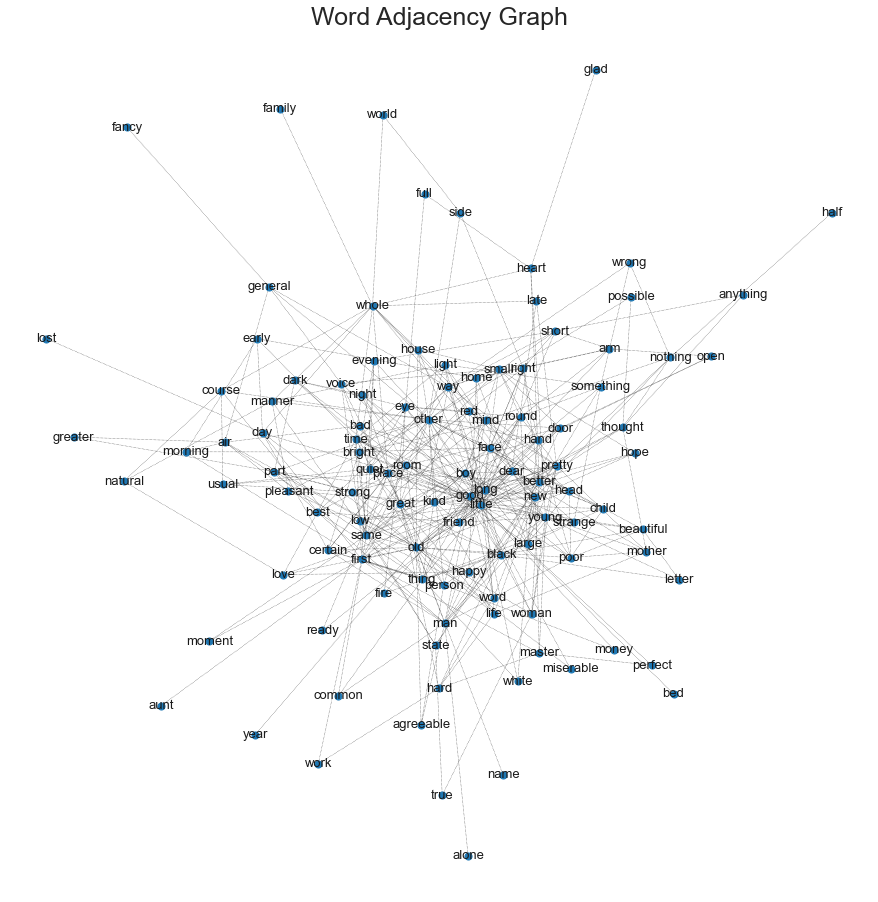

In [266]:
plt.figure(3,figsize=(12,12)) 
nx.draw(G, with_labels=True, font_weight='normal', font_size=13, node_size=50, width=.5, style="dotted")
plt.title("Word Adjacency Graph", fontsize=25)
plt.show()

In [267]:
M = nx.to_numpy_array(G)

In [268]:
output, losses = projection_descent(M, step_size=.01, steps=10000, params=2)

0 0.5340613806645375
1 0.438783848033326
2 0.37704927672640376
3 0.3352778913875026
4 0.30585631510783345
5 0.28439480668060196
6 0.26826389651902466
7 0.25582614556465694
8 0.24602432303800445
9 0.23815322859327823
10 0.231728669483
11 0.22640957161955955
12 0.22195015923443723
13 0.21816971729742898
14 0.2149329540699024
15 0.21213693577146595
16 0.20970220157642366
17 0.2075666003357303
18 0.2056809374464407
19 0.20400584921578555
20 0.20250952454710905
21 0.20116602114573454
22 0.19995400518205764
23 0.19885579678114054
24 0.1978566392369666
25 0.19694413385062673
26 0.19610779874533385
27 0.19533872144608383
28 0.19462928306089092
29 0.1939729376343813
30 0.19336403437503746
31 0.1927976734642948
32 0.1922695883663901
33 0.1917760491983806
34 0.19131378294788884
35 0.1908799072532268
36 0.19047187516591077
37 0.19008742885625832
38 0.18972456064013796
39 0.1893814800293147
40 0.18905658576153808
41 0.18874844196616022
42 0.18845575777907864
43 0.18817736984655242
44 0.187912227258

354 0.17700179502023067
355 0.176994596991833
356 0.1769874267820198
357 0.17698028419303358
358 0.17697316902916493
359 0.17696608109672474
360 0.1769590202040173
361 0.17695198616131344
362 0.17694497878082474
363 0.17693799787667758
364 0.17693104326488773
365 0.1769241147633358
366 0.17691721219174236
367 0.176910335371644
368 0.17690348412636953
369 0.17689665828101667
370 0.17688985766242912
371 0.1768830820991738
372 0.17687633142151868
373 0.17686960546141095
374 0.17686290405245517
375 0.17685622702989237
376 0.17684957423057907
377 0.17684294549296642
378 0.17683634065708043
379 0.17682975956450156
380 0.17682320205834554
381 0.17681666798324353
382 0.17681015718532356
383 0.17680366951219162
384 0.17679720481291303
385 0.17679076293799456
386 0.1767843437393663
387 0.1767779470703641
388 0.1767715727857124
389 0.17676522074150675
390 0.17675889079519747
391 0.17675258280557243
392 0.17674629663274136
393 0.17674003213811934
394 0.17673378918441102
395 0.17672756763559505
396

700 0.17544732462471246
701 0.17544440648130302
702 0.17544149375518292
703 0.1754385864286059
704 0.17543568448391064
705 0.17543278790352065
706 0.17542989666994338
707 0.17542701076576997
708 0.17542413017367442
709 0.17542125487641347
710 0.1754183848568256
711 0.1754155200978309
712 0.1754126605824303
713 0.17540980629370526
714 0.17540695721481708
715 0.17540411332900657
716 0.17540127461959326
717 0.1753984410699753
718 0.17539561266362869
719 0.17539278938410693
720 0.1753899712150404
721 0.17538715814013606
722 0.17538435014317671
723 0.1753815472080208
724 0.1753787493186018
725 0.17537595645892787
726 0.17537316861308117
727 0.17537038576521755
728 0.17536760789956615
729 0.1753648350004289
730 0.17536206705217983
731 0.17535930403926522
732 0.1753565459462024
733 0.17535379275757998
734 0.1753510444580569
735 0.17534830103236254
736 0.17534556246529565
737 0.17534282874172447
738 0.17534009984658605
739 0.17533737576488587
740 0.17533465648169744
741 0.17533194198216187
742

1047 0.17467270675371388
1048 0.17467098231433859
1049 0.1746692600380815
1050 0.1746675399202478
1051 0.17466582195615699
1052 0.17466410614114333
1053 0.17466239247055546
1054 0.17466068093975637
1055 0.17465897154412344
1056 0.1746572642790484
1057 0.17465555913993713
1058 0.17465385612220968
1059 0.17465215522130026
1060 0.1746504564326571
1061 0.17464875975174243
1062 0.17464706517403247
1063 0.17464537269501734
1064 0.17464368231020086
1065 0.17464199401510075
1066 0.17464030780524845
1067 0.17463862367618896
1068 0.174636941623481
1069 0.17463526164269683
1070 0.17463358372942214
1071 0.1746319078792561
1072 0.17463023408781134
1073 0.1746285623507137
1074 0.1746268926636024
1075 0.17462522502213
1076 0.17462355942196195
1077 0.17462189585877702
1078 0.17462023432826707
1079 0.17461857482613694
1080 0.17461691734810442
1081 0.17461526188990023
1082 0.174613608447268
1083 0.17461195701596413
1084 0.1746103075917578
1085 0.17460866017043095
1086 0.17460701474777815
1087 0.17460537

1382 0.17419280654731575
1383 0.17419161169420994
1384 0.17419041798834367
1385 0.17418922542781318
1386 0.17418803401071883
1387 0.17418684373516571
1388 0.17418565459926336
1389 0.17418446660112552
1390 0.17418327973887057
1391 0.1741820940106212
1392 0.1741809094145045
1393 0.174179725948652
1394 0.1741785436111994
1395 0.1741773624002869
1396 0.1741761823140591
1397 0.1741750033506647
1398 0.174173825508257
1399 0.1741726487849933
1400 0.1741714731790353
1401 0.17417029868854914
1402 0.17416912531170492
1403 0.17416795304667723
1404 0.1741667818916447
1405 0.17416561184479032
1406 0.1741644429043012
1407 0.17416327506836862
1408 0.17416210833518825
1409 0.1741609427029596
1410 0.17415977816988665
1411 0.17415861473417726
1412 0.17415745239404357
1413 0.1741562911477018
1414 0.17415513099337235
1415 0.17415397192927956
1416 0.17415281395365195
1417 0.1741516570647221
1418 0.17415050126072665
1419 0.17414934653990624
1420 0.17414819290050557
1421 0.17414704034077338
1422 0.1741458888

1715 0.17384859864413826
1716 0.17384770232281885
1717 0.17384680669835595
1718 0.17384591176980602
1719 0.17384501753622741
1720 0.17384412399668014
1721 0.17384323115022604
1722 0.17384233899592874
1723 0.1738414475328536
1724 0.17384055676006782
1725 0.17383966667664028
1726 0.17383877728164165
1727 0.17383788857414434
1728 0.1738370005532226
1729 0.17383611321795223
1730 0.17383522656741104
1731 0.17383434060067832
1732 0.17383345531683525
1733 0.17383257071496463
1734 0.17383168679415115
1735 0.17383080355348104
1736 0.17382992099204236
1737 0.17382903910892478
1738 0.17382815790321984
1739 0.1738272773740206
1740 0.17382639752042195
1741 0.17382551834152038
1742 0.17382463983641414
1743 0.17382376200420313
1744 0.17382288484398897
1745 0.17382200835487494
1746 0.17382113253596598
1747 0.17382025738636872
1748 0.1738193829051914
1749 0.17381850909154403
1750 0.17381763594453817
1751 0.1738167634632871
1752 0.1738158916469057
1753 0.17381502049451056
1754 0.17381415000521988
1755 0

2050 0.1735822504621216
2051 0.17358154401834275
2052 0.1735808380335847
2053 0.1735801325073202
2054 0.17357942743902266
2055 0.17357872282816644
2056 0.17357801867422665
2057 0.17357731497667936
2058 0.17357661173500133
2059 0.17357590894867025
2060 0.1735752066171646
2061 0.17357450473996372
2062 0.17357380331654773
2063 0.17357310234639756
2064 0.17357240182899503
2065 0.1735717017638227
2066 0.17357100215036403
2067 0.17357030298810328
2068 0.1735696042765255
2069 0.17356890601511651
2070 0.17356820820336302
2071 0.17356751084075256
2072 0.17356681392677337
2073 0.1735661174609146
2074 0.1735654214426661
2075 0.17356472587151864
2076 0.17356403074696378
2077 0.17356333606849375
2078 0.17356264183560172
2079 0.17356194804778158
2080 0.17356125470452802
2081 0.1735605618053366
2082 0.17355986934970358
2083 0.17355917733712606
2084 0.17355848576710192
2085 0.1735577946391298
2086 0.17355710395270915
2087 0.17355641370734023
2088 0.17355572390252405
2089 0.1735550345377624
2090 0.1735

2385 0.1733683775211168
2386 0.1733677997929674
2387 0.17336722238524674
2388 0.1733666452976334
2389 0.17336606852980632
2390 0.17336549208144508
2391 0.17336491595222953
2392 0.17336434014184005
2393 0.17336376464995734
2394 0.17336318947626264
2395 0.17336261462043767
2396 0.17336204008216446
2397 0.17336146586112552
2398 0.1733608919570039
2399 0.17336031836948287
2400 0.17335974509824637
2401 0.17335917214297855
2402 0.17335859950336416
2403 0.17335802717908833
2404 0.17335745516983653
2405 0.1733568834752948
2406 0.17335631209514957
2407 0.17335574102908766
2408 0.17335517027679623
2409 0.17335459983796306
2410 0.1733540297122763
2411 0.17335345989942436
2412 0.1733528903990963
2413 0.17335232121098137
2414 0.17335175233476957
2415 0.173351183770151
2416 0.17335061551681627
2417 0.17335004757445654
2418 0.17334947994276323
2419 0.1733489126214283
2420 0.17334834561014403
2421 0.17334777890860312
2422 0.1733472125164988
2423 0.17334664643352454
2424 0.17334608065937449
2425 0.1733

2720 0.17319097250972804
2721 0.17319048653011626
2722 0.17319000078382266
2723 0.17318951527063856
2724 0.1731890299903554
2725 0.17318854494276495
2726 0.1731880601276591
2727 0.17318757554483025
2728 0.17318709119407077
2729 0.1731866070751734
2730 0.17318612318793117
2731 0.17318563953213728
2732 0.17318515610758523
2733 0.1731846729140688
2734 0.17318418995138188
2735 0.17318370721931875
2736 0.17318322471767394
2737 0.1731827424462421
2738 0.17318226040481824
2739 0.17318177859319756
2740 0.17318129701117552
2741 0.17318081565854787
2742 0.1731803345351105
2743 0.1731798536406597
2744 0.17317937297499184
2745 0.17317889253790358
2746 0.17317841232919198
2747 0.17317793234865417
2748 0.1731774525960875
2749 0.17317697307128968
2750 0.1731764937740586
2751 0.17317601470419247
2752 0.17317553586148962
2753 0.17317505724574866
2754 0.17317457885676849
2755 0.17317410069434824
2756 0.17317362275828724
2757 0.17317314504838505
2758 0.17317266756444158
2759 0.1731721903062568
2760 0.173

3055 0.17304004374614226
3056 0.17303962563483624
3057 0.17303920769891465
3058 0.17303878993823504
3059 0.1730383723526552
3060 0.17303795494203317
3061 0.17303753770622696
3062 0.1730371206450948
3063 0.17303670375849514
3064 0.17303628704628649
3065 0.1730358705083276
3066 0.1730354541444773
3067 0.17303503795459463
3068 0.1730346219385387
3069 0.17303420609616885
3070 0.17303379042734457
3071 0.17303337493192544
3072 0.17303295960977125
3073 0.1730325444607419
3074 0.17303212948469748
3075 0.17303171468149817
3076 0.1730313000510044
3077 0.17303088559307664
3078 0.17303047130757554
3079 0.17303005719436196
3080 0.1730296432532969
3081 0.1730292294842414
3082 0.1730288158870568
3083 0.17302840246160445
3084 0.17302798920774592
3085 0.17302757612534303
3086 0.17302716321425746
3087 0.17302675047435134
3088 0.17302633790548683
3089 0.17302592550752618
3090 0.1730255132803318
3091 0.17302510122376644
3092 0.1730246893376927
3093 0.1730242776219736
3094 0.17302386607647205
3095 0.173023

3388 0.17290971019275614
3389 0.1729093434559732
3390 0.1729089768545255
3391 0.17290861038831193
3392 0.1729082440572316
3393 0.1729078778611835
3394 0.17290751180006703
3395 0.17290714587378142
3396 0.1729067800822261
3397 0.1729064144253006
3398 0.1729060489029045
3399 0.17290568351493754
3400 0.17290531826129957
3401 0.17290495314189047
3402 0.17290458815661022
3403 0.17290422330535896
3404 0.17290385858803695
3405 0.17290349400454436
3406 0.17290312955478168
3407 0.1729027652386494
3408 0.17290240105604815
3409 0.17290203700687848
3410 0.17290167309104132
3411 0.1729013093084375
3412 0.17290094565896802
3413 0.17290058214253393
3414 0.1729002187590364
3415 0.17289985550837675
3416 0.1728994923904563
3417 0.17289912940517652
3418 0.17289876655243896
3419 0.1728984038321453
3420 0.17289804124419725
3421 0.1728976787884967
3422 0.17289731646494555
3423 0.17289695427344579
3424 0.1728965922138997
3425 0.17289623028620937
3426 0.17289586849027716
3427 0.1728955068260055
3428 0.17289514

3721 0.17279449747804393
3722 0.1727941707678051
3723 0.17279384416404472
3724 0.17279351766668888
3725 0.1727931912756637
3726 0.17279286499089536
3727 0.17279253881231
3728 0.17279221273983403
3729 0.1727918867733938
3730 0.17279156091291567
3731 0.17279123515832626
3732 0.1727909095095521
3733 0.17279058396651978
3734 0.17279025852915605
3735 0.17278993319738764
3736 0.17278960797114146
3737 0.17278928285034428
3738 0.1727889578349232
3739 0.17278863292480517
3740 0.17278830811991727
3741 0.17278798342018678
3742 0.17278765882554076
3743 0.1727873343359066
3744 0.17278700995121166
3745 0.1727866856713833
3746 0.17278636149634904
3747 0.17278603742603643
3748 0.17278571346037308
3749 0.17278538959928666
3750 0.17278506584270495
3751 0.17278474219055573
3752 0.17278441864276686
3753 0.17278409519926632
3754 0.1727837718599821
3755 0.1727834486248422
3756 0.17278312549377478
3757 0.1727828024667081
3758 0.17278247954357037
3759 0.17278215672428993
3760 0.1727818340087951
3761 0.1727815

4056 0.17269057905276924
4057 0.17269028425205177
4058 0.1726899895363328
4059 0.17268969490555683
4060 0.17268940035966862
4061 0.17268910589861292
4062 0.1726888115223345
4063 0.1726885172307782
4064 0.1726882230238888
4065 0.17268792890161136
4066 0.17268763486389077
4067 0.17268734091067203
4068 0.1726870470419002
4069 0.17268675325752045
4070 0.1726864595574779
4071 0.1726861659417177
4072 0.1726858724101851
4073 0.17268557896282546
4074 0.17268528559958402
4075 0.17268499232040624
4076 0.17268469912523743
4077 0.17268440601402318
4078 0.17268411298670897
4079 0.17268382004324034
4080 0.17268352718356286
4081 0.17268323440762218
4082 0.17268294171536414
4083 0.17268264910673425
4084 0.17268235658167846
4085 0.17268206414014256
4086 0.17268177178207236
4087 0.17268147950741386
4088 0.17268118731611298
4089 0.17268089520811575
4090 0.17268060318336823
4091 0.1726803112418165
4092 0.17268001938340669
4093 0.17267972760808498
4094 0.17267943591579765
4095 0.17267914430649092
4096 0.17

4391 0.17259625454390165
4392 0.17259598538446327
4393 0.17259571629379095
4394 0.1725954472718425
4395 0.17259517831857568
4396 0.17259490943394837
4397 0.17259464061791835
4398 0.17259437187044357
4399 0.17259410319148188
4400 0.1725938345809913
4401 0.17259356603892978
4402 0.17259329756525535
4403 0.17259302915992608
4404 0.17259276082290004
4405 0.1725924925541354
4406 0.17259222435359017
4407 0.17259195622122267
4408 0.17259168815699108
4409 0.1725914201608536
4410 0.1725911522327686
4411 0.17259088437269432
4412 0.1725906165805891
4413 0.17259034885641142
4414 0.1725900812001196
4415 0.17258981361167208
4416 0.17258954609102733
4417 0.17258927863814397
4418 0.17258901125298043
4419 0.17258874393549528
4420 0.1725884766856472
4421 0.17258820950339476
4422 0.17258794238869668
4423 0.17258767534151162
4424 0.17258740836179837
4425 0.17258714144951562
4426 0.1725868746046222
4427 0.17258660782707697
4428 0.1725863411168388
4429 0.17258607447386654
4430 0.17258580789811906
4431 0.172

4724 0.17251018370697285
4725 0.172509935298351
4726 0.17250968694608015
4727 0.17250943865012744
4728 0.1725091904104601
4729 0.1725089422270455
4730 0.17250869409985087
4731 0.17250844602884358
4732 0.17250819801399092
4733 0.17250795005526032
4734 0.17250770215261918
4735 0.17250745430603484
4736 0.17250720651547485
4737 0.17250695878090658
4738 0.1725067111022976
4739 0.1725064634796154
4740 0.17250621591282753
4741 0.17250596840190152
4742 0.17250572094680502
4743 0.17250547354750562
4744 0.17250522620397093
4745 0.17250497891616864
4746 0.17250473168406644
4747 0.17250448450763198
4748 0.17250423738683313
4749 0.17250399032163743
4750 0.1725037433120129
4751 0.1725034963579272
4752 0.17250324945934825
4753 0.17250300261624377
4754 0.17250275582858177
4755 0.17250250909633008
4756 0.17250226241945663
4757 0.17250201579792943
4758 0.17250176923171634
4759 0.17250152272078548
4760 0.17250127626510478
4761 0.17250102986464233
4762 0.17250078351936618
4763 0.17250053722924444
4764 0.1

5056 0.17243062167935777
5057 0.17243039031591006
5058 0.1724301589991537
5059 0.1724299277290629
5060 0.17242969650561196
5061 0.17242946532877523
5062 0.172429234198527
5063 0.17242900311484166
5064 0.1724287720776935
5065 0.17242854108705694
5066 0.17242831014290647
5067 0.1724280792452164
5068 0.17242784839396122
5069 0.17242761758911535
5070 0.17242738683065334
5071 0.17242715611854964
5072 0.17242692545277877
5073 0.17242669483331524
5074 0.17242646426013364
5075 0.17242623373320853
5076 0.17242600325251453
5077 0.17242577281802612
5078 0.17242554242971803
5079 0.1724253120875649
5080 0.17242508179154137
5081 0.1724248515416221
5082 0.1724246213377818
5083 0.17242439117999522
5084 0.17242416106823705
5085 0.17242393100248204
5086 0.17242370098270496
5087 0.1724234710088806
5088 0.17242324108098378
5089 0.1724230111989893
5090 0.17242278136287198
5091 0.17242255157260675
5092 0.17242232182816844
5093 0.17242209212953197
5094 0.17242186247667218
5095 0.17242163286956402
5096 0.1724

5391 0.172355576340534
5392 0.17235535928676518
5393 0.17235514227201565
5394 0.17235492529626512
5395 0.17235470835949332
5396 0.17235449146167997
5397 0.17235427460280475
5398 0.17235405778284754
5399 0.17235384100178805
5400 0.17235362425960607
5401 0.1723534075562814
5402 0.17235319089179385
5403 0.17235297426612317
5404 0.17235275767924937
5405 0.17235254113115217
5406 0.17235232462181155
5407 0.17235210815120727
5408 0.17235189171931928
5409 0.17235167532612755
5410 0.17235145897161197
5411 0.17235124265575244
5412 0.17235102637852895
5413 0.17235081013992148
5414 0.17235059393990998
5415 0.17235037777847445
5416 0.1723501616555949
5417 0.17234994557125144
5418 0.172349729525424
5419 0.17234951351809266
5420 0.17234929754923747
5421 0.17234908161883858
5422 0.17234886572687602
5423 0.17234864987332996
5424 0.17234843405818043
5425 0.17234821828140762
5426 0.17234800254299168
5427 0.17234778684291274
5428 0.17234757118115102
5429 0.17234735555768674
5430 0.1723471399725
5431 0.172

5723 0.17228554247418226
5724 0.17228533734018586
5725 0.17228513223918882
5726 0.17228492717117494
5727 0.1722847221361282
5728 0.17228451713403242
5729 0.17228431216487153
5730 0.17228410722862952
5731 0.17228390232529023
5732 0.17228369745483763
5733 0.1722834926172557
5734 0.17228328781252839
5735 0.1722830830406397
5736 0.17228287830157357
5737 0.17228267359531405
5738 0.17228246892184512
5739 0.17228226428115082
5740 0.1722820596732152
5741 0.17228185509802227
5742 0.17228165055555603
5743 0.17228144604580065
5744 0.17228124156874017
5745 0.17228103712435863
5746 0.17228083271264025
5747 0.17228062833356902
5748 0.1722804239871291
5749 0.17228021967330456
5750 0.17228001539207966
5751 0.17227981114343852
5752 0.17227960692736524
5753 0.17227940274384404
5754 0.1722791985928591
5755 0.17227899447439457
5756 0.1722787903884348
5757 0.17227858633496387
5758 0.17227838231396603
5759 0.17227817832542558
5760 0.1722779743693267
5761 0.17227777044565373
5762 0.17227756655439086
5763 0.1

6058 0.1722185740872102
6059 0.17221837917120664
6060 0.17221818428337765
6061 0.17221798942371022
6062 0.17221779459219175
6063 0.17221759978880938
6064 0.17221740501355032
6065 0.1722172102664018
6066 0.1722170155473511
6067 0.17221682085638543
6068 0.1722166261934921
6069 0.17221643155865834
6070 0.17221623695187147
6071 0.1722160423731187
6072 0.17221584782238739
6073 0.1722156532996648
6074 0.17221545880493827
6075 0.1722152643381951
6076 0.17221506989942262
6077 0.17221487548860823
6078 0.1722146811057392
6079 0.17221448675080295
6080 0.1722142924237868
6081 0.17221409812467808
6082 0.17221390385346425
6083 0.1722137096101327
6084 0.17221351539467072
6085 0.1722133212070659
6086 0.17221312704730554
6087 0.1722129329153771
6088 0.17221273881126792
6089 0.17221254473496556
6090 0.17221235068645743
6091 0.17221215666573098
6092 0.1722119626727737
6093 0.17221176870757304
6094 0.1722115747701165
6095 0.1722113808603916
6096 0.1722111869783858
6097 0.17221099312408664
6098 0.172210799

6392 0.17215496445544648
6393 0.17215477828905004
6394 0.17215459214700693
6395 0.1721544060293069
6396 0.17215421993593993
6397 0.1721540338668958
6398 0.17215384782216434
6399 0.17215366180173544
6400 0.17215347580559892
6401 0.1721532898337447
6402 0.17215310388616265
6403 0.17215291796284266
6404 0.1721527320637746
6405 0.17215254618894837
6406 0.17215236033835393
6407 0.1721521745119811
6408 0.17215198870981985
6409 0.17215180293186014
6410 0.17215161717809185
6411 0.17215143144850495
6412 0.17215124574308938
6413 0.1721510600618351
6414 0.17215087440473206
6415 0.17215068877177025
6416 0.17215050316293962
6417 0.17215031757823018
6418 0.1721501320176319
6419 0.1721499464811348
6420 0.17214976096872883
6421 0.17214957548040402
6422 0.17214939001615048
6423 0.17214920457595814
6424 0.17214901915981703
6425 0.17214883376771722
6426 0.17214864839964875
6427 0.17214846305560166
6428 0.17214827773556599
6429 0.17214809243953189
6430 0.17214790716748932
6431 0.17214772191942843
6432 0.1

6725 0.17209425860143074
6726 0.1720940800230425
6727 0.1720939014659817
6728 0.17209372293024028
6729 0.17209354441581023
6730 0.1720933659226834
6731 0.1720931874508518
6732 0.17209300900030736
6733 0.17209283057104202
6734 0.1720926521630477
6735 0.17209247377631648
6736 0.17209229541084017
6737 0.17209211706661093
6738 0.17209193874362058
6739 0.1720917604418612
6740 0.1720915821613247
6741 0.1720914039020032
6742 0.17209122566388863
6743 0.17209104744697296
6744 0.17209086925124828
6745 0.1720906910767066
6746 0.17209051292333988
6747 0.17209033479114025
6748 0.17209015668009967
6749 0.1720899785902102
6750 0.17208980052146391
6751 0.17208962247385282
6752 0.172089444447369
6753 0.17208926644200453
6754 0.1720890884577515
6755 0.17208891049460193
6756 0.17208873255254795
6757 0.17208855463158163
6758 0.172088376731695
6759 0.17208819885288026
6760 0.17208802099512946
6761 0.17208784315843473
6762 0.1720876653427882
6763 0.17208748754818193
6764 0.17208730977460804
6765 0.172087132

7057 0.17203609630340003
7058 0.17203592439418502
7059 0.17203575250390346
7060 0.17203558063254887
7061 0.1720354087801148
7062 0.17203523694659503
7063 0.172035065131983
7064 0.17203489333627234
7065 0.1720347215594568
7066 0.17203454980152982
7067 0.17203437806248514
7068 0.1720342063423164
7069 0.17203403464101716
7070 0.17203386295858109
7071 0.17203369129500184
7072 0.17203351965027308
7073 0.17203334802438847
7074 0.17203317641734156
7075 0.17203300482912612
7076 0.1720328332597358
7077 0.17203266170916431
7078 0.1720324901774052
7079 0.17203231866445223
7080 0.17203214717029908
7081 0.17203197569493947
7082 0.17203180423836703
7083 0.17203163280057546
7084 0.1720314613815585
7085 0.17203128998130984
7086 0.17203111859982317
7087 0.17203094723709225
7088 0.17203077589311075
7089 0.17203060456787242
7090 0.17203043326137102
7091 0.1720302619736002
7092 0.17203009070455375
7093 0.1720299194542254
7094 0.1720297482226089
7095 0.17202957700969804
7096 0.17202940581548645
7097 0.1720

7391 0.1719796942892552
7392 0.1719795283736205
7393 0.17197936247501056
7394 0.17197919659342042
7395 0.1719790307288449
7396 0.17197886488127906
7397 0.17197869905071775
7398 0.17197853323715592
7399 0.17197836744058856
7400 0.17197820166101055
7401 0.17197803589841693
7402 0.17197787015280258
7403 0.17197770442416246
7404 0.17197753871249166
7405 0.171977373017785
7406 0.1719772073400375
7407 0.17197704167924413
7408 0.17197687603539988
7409 0.17197671040849974
7410 0.17197654479853866
7411 0.17197637920551165
7412 0.17197621362941373
7413 0.17197604807023986
7414 0.17197588252798504
7415 0.17197571700264425
7416 0.17197555149421254
7417 0.17197538600268492
7418 0.17197522052805636
7419 0.17197505507032196
7420 0.1719748896294766
7421 0.1719747242055154
7422 0.17197455879843343
7423 0.17197439340822562
7424 0.17197422803488702
7425 0.17197406267841275
7426 0.17197389733879773
7427 0.17197373201603708
7428 0.17197356671012587
7429 0.17197340142105907
7430 0.1719732361488318
7431 0.17

7725 0.17192519574139883
7726 0.17192503525054204
7727 0.17192487477519794
7728 0.17192471431536246
7729 0.1719245538710317
7730 0.17192439344220153
7731 0.17192423302886803
7732 0.17192407263102702
7733 0.17192391224867465
7734 0.17192375188180686
7735 0.17192359153041964
7736 0.171923431194509
7737 0.17192327087407097
7738 0.17192311056910153
7739 0.17192295027959664
7740 0.17192279000555233
7741 0.1719226297469647
7742 0.17192246950382967
7743 0.1719223092761433
7744 0.17192214906390157
7745 0.1719219888671005
7746 0.17192182868573622
7747 0.17192166851980464
7748 0.17192150836930187
7749 0.17192134823422392
7750 0.17192118811456678
7751 0.17192102801032652
7752 0.17192086792149922
7753 0.1719207078480809
7754 0.1719205477900676
7755 0.17192038774745533
7756 0.17192022772024027
7757 0.1719200677084183
7758 0.17191990771198568
7759 0.1719197477309383
7760 0.1719195877652723
7761 0.17191942781498376
7762 0.1719192678800687
7763 0.17191910796052323
7764 0.1719189480563434
7765 0.171918

8058 0.1718725865814522
8059 0.17187243104975544
8060 0.1718722755323721
8061 0.171872120029299
8062 0.1718719645405329
8063 0.17187180906607058
8064 0.1718716536059089
8065 0.17187149816004457
8066 0.17187134272847446
8067 0.17187118731119533
8068 0.171871031908204
8069 0.1718708765194972
8070 0.1718707211450719
8071 0.17187056578492474
8072 0.17187041043905266
8073 0.17187025510745238
8074 0.17187009979012077
8075 0.17186994448705462
8076 0.17186978919825077
8077 0.17186963392370602
8078 0.17186947866341717
8079 0.17186932341738112
8080 0.17186916818559467
8081 0.17186901296805462
8082 0.17186885776475777
8083 0.17186870257570108
8084 0.17186854740088126
8085 0.17186839224029518
8086 0.17186823709393972
8087 0.17186808196181172
8088 0.17186792684390798
8089 0.17186777174022536
8090 0.17186761665076075
8091 0.17186746157551094
8092 0.1718673065144728
8093 0.17186715146764323
8094 0.17186699643501907
8095 0.17186684141659708
8096 0.1718666864123743
8097 0.17186653142234742
8098 0.17186

8393 0.17182126531846514
8394 0.1718211144144024
8395 0.17182096352368578
8396 0.17182081264631263
8397 0.17182066178228037
8398 0.17182051093158643
8399 0.17182036009422819
8400 0.17182020927020314
8401 0.1718200584595086
8402 0.17181990766214206
8403 0.17181975687810092
8404 0.17181960610738256
8405 0.17181945534998452
8406 0.17181930460590408
8407 0.17181915387513877
8408 0.171819003157686
8409 0.1718188524535432
8410 0.17181870176270775
8411 0.17181855108517718
8412 0.17181840042094884
8413 0.1718182497700202
8414 0.1718180991323887
8415 0.1718179485080518
8416 0.17181779789700688
8417 0.17181764729925145
8418 0.1718174967147829
8419 0.17181734614359873
8420 0.17181719558569636
8421 0.17181704504107326
8422 0.17181689450972684
8423 0.17181674399165456
8424 0.17181659348685394
8425 0.17181644299532234
8426 0.1718162925170573
8427 0.17181614205205623
8428 0.17181599160031658
8429 0.17181584116183587
8430 0.17181569073661151
8431 0.171815540324641
8432 0.17181538992592177
8433 0.17181

8726 0.17177173697739906
8727 0.1717715903835384
8728 0.17177144380224213
8729 0.17177129723350815
8730 0.1717711506773343
8731 0.17177100413371849
8732 0.1717708576026586
8733 0.17177071108415246
8734 0.17177056457819803
8735 0.17177041808479313
8736 0.17177027160393563
8737 0.17177012513562345
8738 0.1717699786798545
8739 0.1717698322366266
8740 0.17176968580593763
8741 0.17176953938778552
8742 0.1717693929821682
8743 0.17176924658908352
8744 0.17176910020852934
8745 0.17176895384050359
8746 0.17176880748500414
8747 0.17176866114202893
8748 0.1717685148115758
8749 0.17176836849364266
8750 0.17176822218822743
8751 0.17176807589532805
8752 0.17176792961494233
8753 0.17176778334706821
8754 0.17176763709170356
8755 0.1717674908488464
8756 0.17176734461849452
8757 0.17176719840064586
8758 0.17176705219529834
8759 0.1717669060024499
8760 0.17176675982209835
8761 0.1717666136542417
8762 0.17176646749887778
8763 0.1717663213560046
8764 0.17176617522562
8765 0.17176602910772196
8766 0.1717658

9061 0.17172331832623366
9062 0.1717231758293818
9063 0.17172303334444244
9064 0.17172289087141396
9065 0.17172274841029453
9066 0.1717226059610823
9067 0.17172246352377551
9068 0.1717223210983725
9069 0.17172217868487133
9070 0.17172203628327032
9071 0.17172189389356765
9072 0.17172175151576163
9073 0.17172160914985035
9074 0.17172146679583214
9075 0.1717213244537052
9076 0.17172118212346774
9077 0.17172103980511802
9078 0.1717208974986542
9079 0.17172075520407462
9080 0.17172061292137744
9081 0.17172047065056087
9082 0.17172032839162327
9083 0.1717201861445627
9084 0.1717200439093775
9085 0.17171990168606588
9086 0.17171975947462612
9087 0.1717196172750564
9088 0.17171947508735494
9089 0.17171933291152008
9090 0.17171919074755
9091 0.1717190485954429
9092 0.1717189064551971
9093 0.17171876432681077
9094 0.17171862221028222
9095 0.17171848010560956
9096 0.17171833801279124
9097 0.1717181959318254
9098 0.1717180538627103
9099 0.1717179118054441
9100 0.17171776976002517
9101 0.171717627

9394 0.17167651492201158
9395 0.17167637629846225
9396 0.17167623768627552
9397 0.17167609908544992
9398 0.17167596049598385
9399 0.17167582191787578
9400 0.17167568335112418
9401 0.17167554479572755
9402 0.1716754062516843
9403 0.171675267718993
9404 0.17167512919765202
9405 0.1716749906876599
9406 0.171674852189015
9407 0.17167471370171597
9408 0.17167457522576113
9409 0.1716744367611491
9410 0.1716742983078782
9411 0.17167415986594697
9412 0.1716740214353539
9413 0.17167388301609743
9414 0.17167374460817608
9415 0.17167360621158836
9416 0.17167346782633264
9417 0.17167332945240746
9418 0.1716731910898113
9419 0.1716730527385427
9420 0.1716729143986
9421 0.17167277606998174
9422 0.17167263775268649
9423 0.17167249944671262
9424 0.17167236115205867
9425 0.17167222286872313
9426 0.1716720845967044
9427 0.1716719463360011
9428 0.17167180808661162
9429 0.1716716698485345
9430 0.17167153162176815
9431 0.17167139340631113
9432 0.1716712552021619
9433 0.17167111700931892
9434 0.171670978827

9730 0.17163056759675188
9731 0.1716304327083809
9732 0.17163029783088912
9733 0.17163016296427527
9734 0.171630028108538
9735 0.17162989326367592
9736 0.17162975842968772
9737 0.17162962360657205
9738 0.17162948879432752
9739 0.17162935399295276
9740 0.17162921920244653
9741 0.17162908442280742
9742 0.17162894965403402
9743 0.1716288148961251
9744 0.1716286801490792
9745 0.17162854541289504
9746 0.17162841068757126
9747 0.17162827597310648
9748 0.1716281412694994
9749 0.17162800657674865
9750 0.17162787189485287
9751 0.1716277372238108
9752 0.17162760256362097
9753 0.17162746791428216
9754 0.1716273332757929
9755 0.17162719864815196
9756 0.1716270640313579
9757 0.1716269294254095
9758 0.17162679483030532
9759 0.17162666024604406
9760 0.17162652567262432
9761 0.17162639111004485
9762 0.17162625655830424
9763 0.17162612201740118
9764 0.17162598748733432
9765 0.17162585296810234
9766 0.17162571845970392
9767 0.17162558396213765
9768 0.17162544947540223
9769 0.17162531499949638
9770 0.171

In [226]:
log_likelihood(M, np.clip(rank_d_approx(M,2),.000001,.999999), use_sigmoid=False)

-0.18356077321504488

In [240]:
output

array([[-33.90122547,  -0.37233951,  -3.01338699, ...,  -6.37250593,
         -5.10790989, -15.67557383],
       [ -0.37233951, -31.56025536,   0.10021515, ..., -37.89406882,
        -19.96543474, -20.94671798],
       [ -3.01338699,   0.10021515,  -0.26841489, ...,  -0.40664393,
         -0.36991963,  -1.30559513],
       ...,
       [ -6.37250593, -37.89406882,  -0.40664393, ..., -46.53482783,
        -24.8240175 , -27.84752382],
       [ -5.10790989, -19.96543474,  -0.36991963, ..., -24.8240175 ,
        -13.33075603, -15.46887078],
       [-15.67557383, -20.94671798,  -1.30559513, ..., -27.84752382,
        -15.46887078, -20.92485245]])

In [241]:
np.round(sigmoid(output),2)

array([[0.  , 0.41, 0.05, ..., 0.  , 0.01, 0.  ],
       [0.41, 0.  , 0.53, ..., 0.  , 0.  , 0.  ],
       [0.05, 0.53, 0.43, ..., 0.4 , 0.41, 0.21],
       ...,
       [0.  , 0.  , 0.4 , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.41, ..., 0.  , 0.  , 0.  ],
       [0.  , 0.  , 0.21, ..., 0.  , 0.  , 0.  ]])

In [242]:
Labels = get_labels(output, num_labels=2)
labels = np.absolute(Labels)

In [269]:
labels = np.real(get_labels(sigmoid(output))) + np.imag(get_labels(sigmoid(output)))

In [270]:
L = np.array([list(G.nodes(data=True))[i][1]['value'] for i in range(len(G.nodes))])

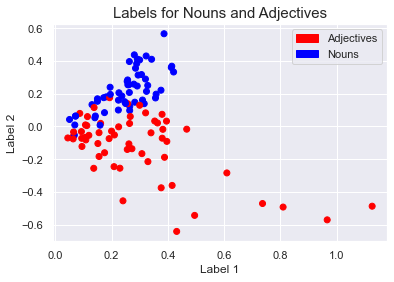

In [271]:
plt.scatter(labels[0], labels[1], color = ["red" if elt == 0 else "blue" for elt in L])
plt.xlabel("Label 1", fontsize=12)
plt.ylabel("Label 2", fontsize=12)
plt.title("Labels for Nouns and Adjectives", fontsize=15)

red_patch = mpatches.Patch(color='red', label='Adjectives')
blue_patch = mpatches.Patch(color='blue', label='Nouns')
plt.legend(handles=[red_patch, blue_patch])

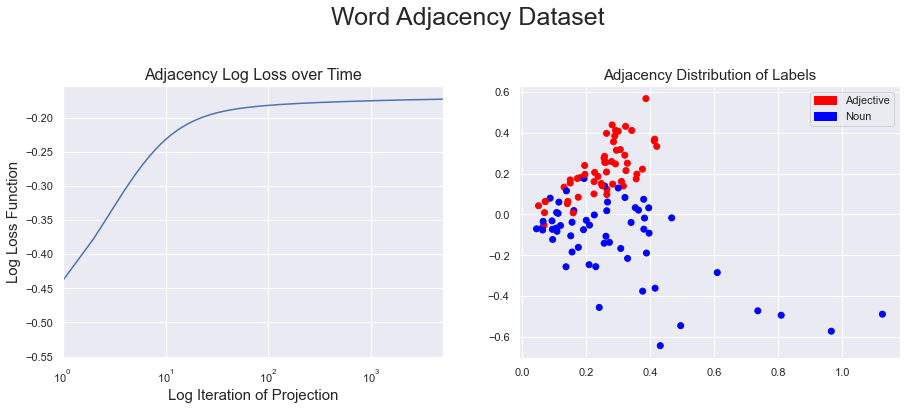

In [272]:
fig=plt.figure(figsize=(15,10))
fig.set_figheight(11)
fig.set_figwidth(15)
ax1=fig.add_subplot(2,2,1)
ax2=fig.add_subplot(2,2,2)
fig.suptitle('Word Adjacency Dataset', fontsize=25)
ax1.plot(-np.array(losses))
ax1.set_xlabel('Log Iteration of Projection', fontsize=15)
ax1.set_ylabel('Log Loss Function', fontsize=15)
ax1.set_title('Adjacency Log Loss over Time', fontsize=16)
ax1.set_xscale('log')
ax1.set_xlim(1,5000)
#ax2 = Axes3D(fig)
ax2.scatter(labels[0], labels[1], color = ["blue" if elt == 0 else "red" for elt in L])
ax2.set_title("Adjacency Distribution of Labels", fontsize=15)

red_patch = mpatches.Patch(color='red', label='Adjective')
blue_patch = mpatches.Patch(color='blue', label='Noun')
ax2.legend(handles=[red_patch, blue_patch])

In [100]:
L

array([0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       1, 1])

In [101]:
dist_mat = distance_matrix(labels.T, labels.T)

In [102]:
#average distance between any two nouns
vals = 0
total = 0
for i in range(len(dist_mat)):
    for j in range(len(dist_mat[i])):
        if L[i] == 0 and L[j] == 0 and i != j:
            vals +=1
            total +=dist_mat[i][j]
print(total/vals)

2.0547388306353414


In [103]:
#average distance between any two nouns
vals = 0
total = 0
for i in range(len(dist_mat)):
    for j in range(len(dist_mat[i])):
        if L[i] == 0 and L[j] == 1 and i != j:
            vals +=1
            total +=dist_mat[i][j]
print(total/vals)

2.1554328073154396


In [104]:
#average distance between any two nouns
vals = 0
total = 0
for i in range(len(dist_mat)):
    for j in range(len(dist_mat[i])):
        if L[i] == 1 and L[j] == 1 and i != j:
            vals +=1
            total +=dist_mat[i][j]
print(total/vals)

2.0995364759990096


In [ ]:
#average distance between any two nouns
vals = 0
total = 0
for i in range(len(dist_mat)):
    for j in range(len(dist_mat[i])):
        if L[i] == 0 and L[j] == 1 and i != j:
            vals +=1
            total +=dist_mat[i][j]
print(total/vals)

In [56]:
len(dist_mat[(L == 1)])

54

In [57]:
len(dist_mat[(L == 0)])

58

# Collaborator Dataset

In [121]:
G = nx.read_edgelist("/Users/prupes/Downloads/facebook/0.edges")
G = nx.Graph(G)
G = nx.to_undirected(G)

In [122]:
len(G.nodes)

333

In [123]:
G.nodes(data=True)

NodeDataView({'236': {}, '186': {}, '122': {}, '285': {}, '24': {}, '346': {}, '271': {}, '304': {}, '176': {}, '9': {}, '130': {}, '329': {}, '204': {}, '213': {}, '252': {}, '332': {}, '82': {}, '65': {}, '276': {}, '26': {}, '280': {}, '272': {}, '211': {}, '199': {}, '84': {}, '133': {}, '62': {}, '239': {}, '172': {}, '322': {}, '53': {}, '3': {}, '170': {}, '175': {}, '46': {}, '56': {}, '254': {}, '194': {}, '231': {}, '117': {}, '127': {}, '135': {}, '103': {}, '188': {}, '23': {}, '116': {}, '73': {}, '299': {}, '288': {}, '315': {}, '119': {}, '323': {}, '48': {}, '57': {}, '200': {}, '98': {}, '313': {}, '63': {}, '344': {}, '67': {}, '118': {}, '325': {}, '277': {}, '134': {}, '270': {}, '76': {}, '36': {}, '223': {}, '274': {}, '88': {}, '21': {}, '339': {}, '108': {}, '197': {}, '169': {}, '275': {}, '273': {}, '83': {}, '28': {}, '312': {}, '242': {}, '214': {}, '20': {}, '307': {}, '71': {}, '333': {}, '207': {}, '168': {}, '308': {}, '341': {}, '128': {}, '334': {}, '2

In [146]:
len(G.edges)

2519

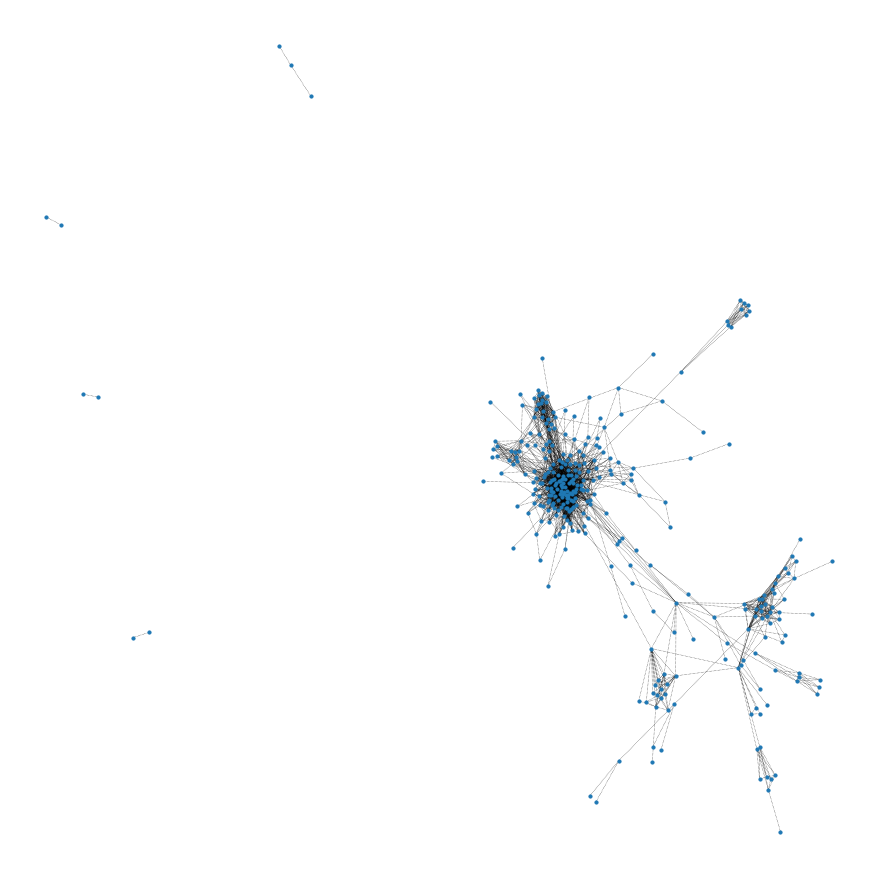

In [124]:
plt.figure(3,figsize=(12,12)) 
nx.draw(G, with_labels=False, font_weight='normal', font_size=13, node_size=10, width=.5, style="dotted")
plt.show()

In [126]:
M = nx.to_numpy_array(G)

In [128]:
output = projection_descent(M, step_size=.05, steps=200, params=5)

0 (-0.25132395687497266+0j)
1 (-0.1699784682510802+0j)
2 (-0.1400996492295781+0j)
3 (-0.12506430974703941+0j)
4 (-0.11608399059391314+0j)
5 (-0.11010749534285119-1.1095297818049903e-35j)
6 (-0.10581673745077036+2.3284611949423837e-35j)
7 (-0.10255666345435814-1.2020973821488317e-35j)
8 (-0.09996920810801964+7.167577186853203e-36j)
9 (-0.09784490547743818+6.047671105249786e-36j)
10 (-0.09605478929551585+6.004792629820631e-36j)
11 (-0.0945159949727278-4.306126201589919e-36j)
12 (-0.0931730663644833-4.52647421668842e-35j)
13 (-0.0919872883961439-2.5296053566686527e-35j)
14 (-0.09093044480221288-1.7637276573654076e-35j)
15 (-0.08998112944439975-1.5760318695488144e-35j)
16 (-0.08912254721931143+3.2021189622500457e-36j)
17 (-0.08834117438769759+1.9564767164805585e-35j)
18 (-0.08762590931420483+1.2148003648209977e-35j)
19 (-0.08696750560389493+9.314242417991748e-36j)
20 (-0.08635817442289641+8.325785679127157e-36j)
21 (-0.08579129494785846+8.16412521447658e-36j)
22 (-0.0852611990202324+8.4303

168 (-0.06786609084637558+3.479885693398519e-31j)
169 (-0.06783156915280986+3.6215108926238146e-31j)
170 (-0.06779724748861228+3.7378118388253626e-31j)
171 (-0.06776312226271852+3.832147993968274e-31j)
172 (-0.06772919001602679+3.9073344379622177e-31j)
173 (-0.06769544742002483+3.965716005345455e-31j)
174 (-0.0676618912753643+4.010570720648304e-31j)
175 (-0.06762851851036945+4.042023779630472e-31j)
176 (-0.06759532617946948+4.06068526660386e-31j)
177 (-0.06756231146154244+4.0701542015782e-31j)
178 (-0.06752947165816113+4.070952999649069e-31j)
179 (-0.06749680419173182+4.064189945622256e-31j)
180 (-0.06746430660351688+4.050774022969042e-31j)
181 (-0.06743197655153466+4.031530566655625e-31j)
182 (-0.067399811808331+4.007198948091143e-31j)
183 (-0.06736781025861666+3.978438233065758e-31j)
184 (-0.06733596989676859+3.9458348202292295e-31j)
185 (-0.06730428882419237+3.9099100608475908e-31j)
186 (-0.0672727652465459+3.8711272782482226e-31j)
187 (-0.06724139747082511+3.8298980465579048e-31j)


In [130]:
np.round(sigmoid(np.abs(output)),2)

array([[0.52, 0.55, 0.82, ..., 1.  , 1.  , 1.  ],
       [0.55, 0.99, 0.83, ..., 1.  , 1.  , 1.  ],
       [0.82, 0.83, 1.  , ..., 1.  , 1.  , 1.  ],
       ...,
       [1.  , 1.  , 1.  , ..., 1.  , 1.  , 1.  ],
       [1.  , 1.  , 1.  , ..., 1.  , 0.99, 1.  ],
       [1.  , 1.  , 1.  , ..., 1.  , 1.  , 0.99]])

In [ ]:
M = nx.to_numpy_array(G)

In [252]:
BLOG = nx.read_gml("polblogs.gml")
BLOG = nx.Graph(BLOG)
BLOG = nx.to_undirected(BLOG)

In [253]:
len(BLOG.nodes)

1490

In [255]:
len(BLOG.edges)

16718

In [254]:
BLOG.nodes

NodeView(('100monkeystyping.com', '12thharmonic.com/wordpress', '40ozblog.blogspot.com', '4lina.tblog.com', '750volts.blogspot.com', '95theses.blogspot.com', 'abbadabbaduo.blogspot.com', 'aboutpolitics.blogspot.com', 'achingandspinning.blogspot.com', 'ackackack.com', 'adamtalib.blogspot.com', 'adviceforlefty.blogspot.com', 'agonist.org', 'aintnobaddude.com', 'ajbenjaminjr.blogspot.com', 'alicublog.blogspot.com', 'allanjenkins.typepad.com', 'allspinzone.blogspot.com', 'alphapredator.com/wdtgw.htm', 'alternateworlds.blogspot.com', 'althippo.blogspot.com', 'alvintostig.typepad.com', 'americablog.blogspot.com', 'americablog.org', 'americandreamslost.blogspot.com', 'americanmuslim.blogs.com', 'americanpolitics.com', 'americansforbayh.blogspot.com', 'amleft.blogspot.com', 'amliberal.com/blog', 'amptoons.com/blog', 'anarchyxero.robfindlay.org', 'andifeelfine.blogspot.com', 'andymatic.com', 'angrybear.blogspot.com', 'angrydesi.typepad.com', 'angryfinger.org', 'angryhomo.blogspot.com', 'annatop